In [1]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

mpl.rcParams['figure.figsize'] = (6,5)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image, HTML
plt.set_cmap('Spectral');

def audiofigure(func,duration, audio_path, sr = 44100, dpi=60, fps=4, ylim=(-1, 1),videoname=None,HTML_OUT=True):

    from matplotlib import animation, rc
    import matplotlib.pyplot as plt
    from IPython.display import HTML
    from base64 import encodebytes
    import subprocess
    import os
    import tempfile
    
    t = np.arange(duration*sr)/float(sr)
    interval = 1000.0/fps
    frames = int(duration*fps)

    fig,ax = func()

    video_size = np.array(fig.get_size_inches())*dpi

    ax.set_xlim(( 0, duration))
    ax.set_ylim(ylim)

    line, = ax.plot([], [], color='r',lw=3)
    
    def init():
        line.set_data([], [])
        return (line,)

 
    def animate(i):
        x = np.array([i, i])/float(fps)
        y = ylim
        
        line.set_data(x, y)
        
        return (line,)

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=interval, blit=True);


    input_filename = tempfile.NamedTemporaryFile(delete=False).name+'.mp4'
    # print(input_filename)

    anim.save(input_filename,codec='h264')


    plt.close()

    if not videoname:
        videoname='out.mp4'

    command = ['ffmpeg', '-i', input_filename,'-y', '-i', audio_path ,'-c:v', 'libx264', '-c:a', 'libvorbis', 
               '-shortest', videoname]

    proc = subprocess.Popen(command, shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                                          stdin=subprocess.PIPE)
    proc.communicate()

    os.unlink(input_filename)
    
    if HTML_OUT:
        VIDEO_TAG = r'''<video {size} {options}>
          <source type="video/mp4" src="data:video/mp4;base64,{video}">
          Your browser does not support the video tag.
        </video>'''


        with open(videoname, 'rb') as video:
            vid64 = encodebytes(video.read())
            _base64_video = vid64.decode('ascii')
            _video_size = 'width="{0}" height="{1}"'.format(*video_size)

        options = ['controls', 'autoplay']
        
        #os.remove("in.mp4")
        #os.remove("out.mp4")

        html = VIDEO_TAG.format(video=_base64_video, size=_video_size, options=' '.join(options))
        return HTML(html)

def dmd(x):
    display(Markdown(x))
    
from IPython.core.display import HTML
display(HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
"""))

# Números y Datos
import numpy as np
import pandas as pd

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform

# Clustering (sklearn)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster, datasets, mixture

<Figure size 432x360 with 0 Axes>

# Análisis Espectral

## Autovalores y autovectores

El análisis de autovalores y autovectores, en muchos casos, permite entender la información que contiene una matriz.

$$ {\displaystyle \mathbf {A} \mathbf {v} =c\mathbf {v} ,\qquad \mathbf {v} \neq \mathbf {0} ,c\in \mathbb {K} ,} $$

Por ejemplo si A es una matriz cuadrada invertible esta se puede descomponer de la siguiente forma 

$$A=VDV^{{-1}}$$. 

Donde $V$ es la matriz con los autovectores y $D$ una matriz diagonal con los autovalores. En muchos casos esta descomposición permite reducir la dimensionalidad de un conjunto de datos dependiendo de que matriz se construya a partir de los datos.

## Matriz de correlación o covariancia (PCA)

Si se descompone la matriz de correlación o de covarianza centrada, obtenemos autovectores que indican las componentes principales y autovalores que indican la varianza explicada por cada componente.

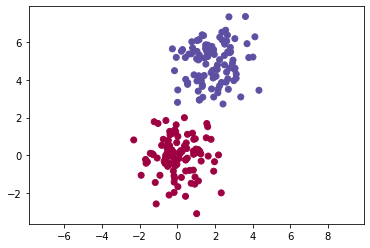

In [18]:
X,y = datasets.make_blobs(n_samples=200,n_features=2,centers=((0,0),(2,5)),shuffle=False)
plt.scatter(X[:,0],X[:,1],c=y)
plt.axis('equal');

Calculo de covarianza:

$$\displaystyle C = \frac{X^{T} \cdot X}{n-1}$$

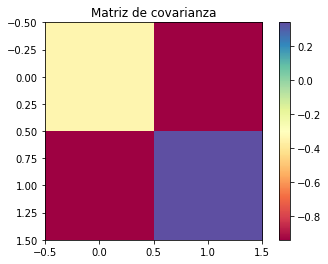

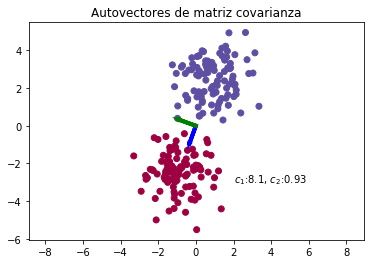

In [19]:
n, m = X.shape
Xcentered = X - X.mean(0)
C = np.dot(Xcentered.T, Xcentered) / (n-1)

d, V = np.linalg.eig(C)

ix = np.argsort(d)[::-1]
d = d[ix]
V = V[:,ix]

plt.figure()
plt.imshow(V)
plt.colorbar()
plt.title('Matriz de covarianza')

plt.figure()
plt.scatter(Xcentered[:,0],Xcentered[:,1],c=y)

pc1 = V[:,0]
pc2 = V[:,1]

plt.arrow(0,0,pc1[0],pc1[1],lw=4,color='b');
plt.arrow(0,0,pc2[0],pc2[1],lw=4,color='g');
plt.axis('equal');

plt.text(2,-3,'$c_1$:{:0.2g}, $c_2$:{:0.2g}'.format(d[0],d[1]),);
plt.title('Autovectores de matriz covarianza');

## Matrices de distancia

Si cambiamos la orientación de la matriz y hacemos la misma operación obtenemos una matriz de distancia:

$$\displaystyle C = \frac{X \cdot X^{T}}{m-1}$$

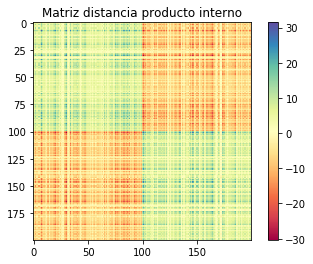

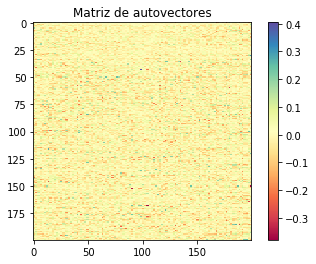

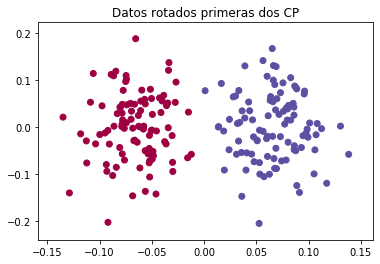

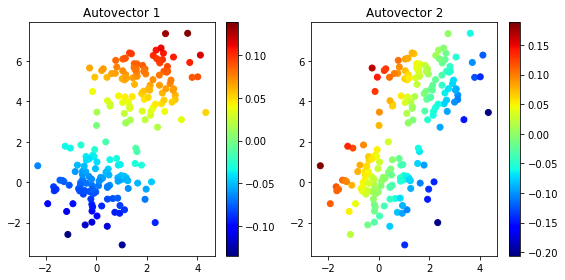

In [20]:
n, m = X.shape
Xcentered = X - X.mean(0)
C = np.dot(Xcentered, Xcentered.T)/(m-1)

plt.imshow(C)
plt.colorbar();
plt.title('Matriz distancia producto interno')

d, V = np.linalg.eig(C)

idx = np.argsort(d)[::-1]
d = d[idx].real
V = V[:,idx].real

plt.figure()
plt.imshow(V)
plt.title('Matriz de autovectores')
plt.colorbar();

plt.figure()
plt.scatter(V[:,0],V[:,1],c=y);
plt.title('Datos rotados primeras dos CP')

plt.figure(figsize=(8,4))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.scatter(X[:,0],X[:,1],c=V[:,i].real,cmap=plt.cm.jet);
    plt.title('Autovector {}'.format(i+1))
    plt.colorbar();
    
plt.tight_layout()

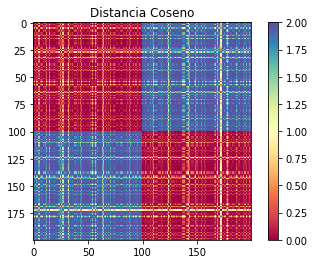

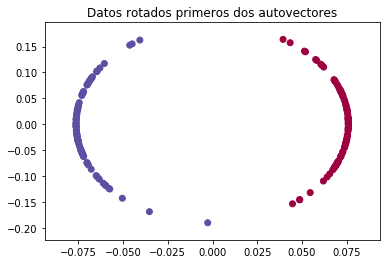

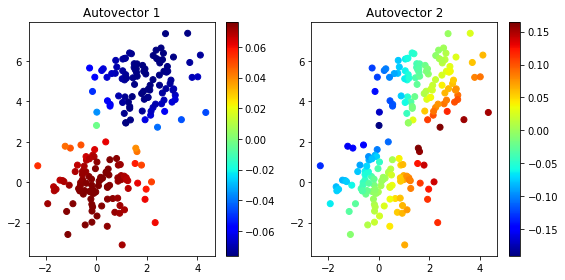

In [21]:
C = squareform(pdist(Xcentered, metric='cosine'))
plt.imshow(C)
plt.colorbar();
plt.title('Distancia Coseno')

d, V = np.linalg.eig(C)

idx = np.argsort(d)
d = d[idx].real
V = V[:,idx].real

plt.figure()
plt.scatter(V[:,0],V[:,1],c=y);
plt.title('Datos rotados primeros dos autovectores')

plt.figure(figsize=(8,4))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.scatter(X[:,0],X[:,1],c=V[:,i].real,cmap=plt.cm.jet);
    plt.title('Autovector {}'.format(i+1))
    plt.colorbar()
    
plt.tight_layout()

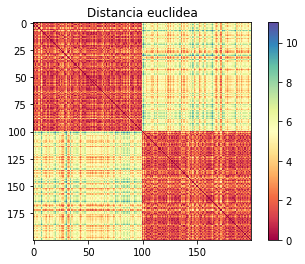

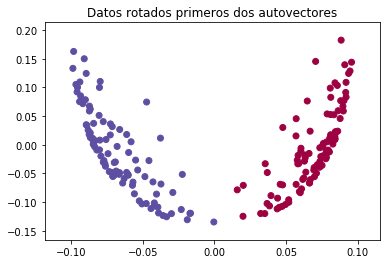

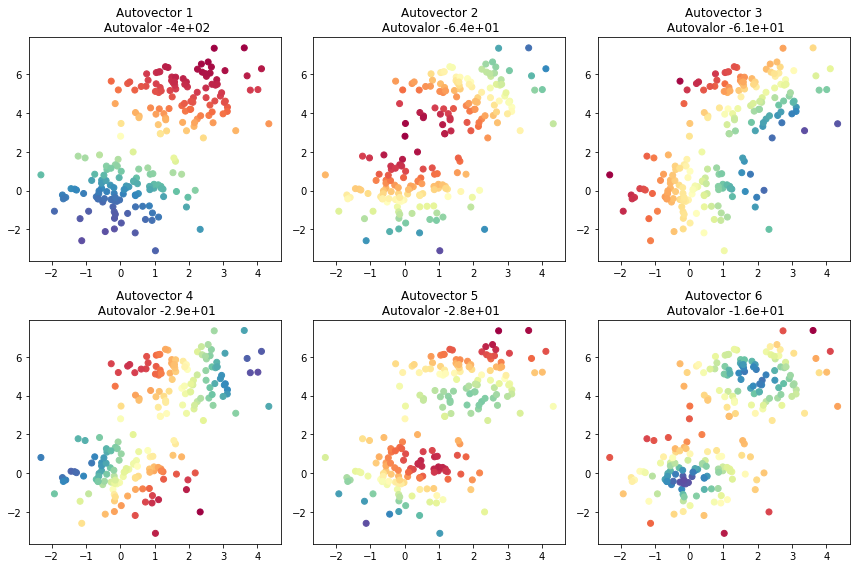

In [22]:
n, m = X.shape
C = squareform(pdist(X,metric='euclidean'))
plt.imshow(C)
plt.colorbar();
plt.title('Distancia euclidea')

d, V = np.linalg.eig(C)

idx = np.argsort(d)
d = d[idx].real
V = V[:,idx].real

plt.figure()
plt.scatter(V[:,0],V[:,1],c=y);
plt.title('Datos rotados primeros dos autovectores')

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(X[:,0],X[:,1],c=V[:,i].real);
    plt.title('Autovector {}\n Autovalor {:0.2}'.format(i+1,d[i]))
    
plt.tight_layout()

## Matriz Laplaciana

Dado un conjunto de datos es posible constriur un grafo de vecinos próximos (nearest neighbors) y calcular la matriz Laplaciana para realizar el análisis de autovectores.

La matriz Laplaciana $L$ se construye como $L=D-A$, donde $A$ es la matriz de adyacencia y contiene la información de la conectividad del grafo y $D$ es una matriz diagonal construida a partir del grado de cada nodo del grafo.   

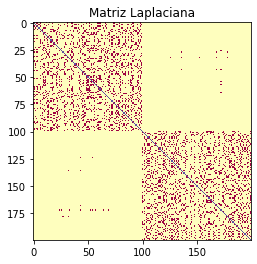

In [23]:
nn = NearestNeighbors(n_neighbors=20,).fit(X)
A = np.array(nn.kneighbors_graph().todense())

D = np.diag(A.sum(1))
L = D - A
plt.imshow(L,vmax=1);
plt.title('Matriz Laplaciana');

![https://miro.medium.com/max/864/1*p2vrLlFxdJgGZxCGO5WBmA.gif](https://miro.medium.com/max/864/1*p2vrLlFxdJgGZxCGO5WBmA.gif)

Calculamos los autovectores y autovalores de $L$


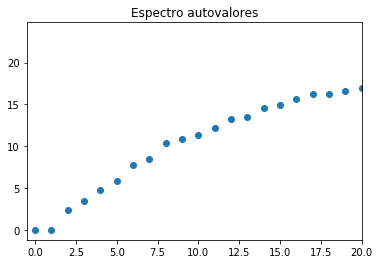

In [24]:
d, V = np.linalg.eig(L)

idx = np.argsort(d)
d = d[idx].real
V = V[:,idx].real

plt.plot(d,'o')
plt.xlim(-0.5,20);
plt.title('Espectro autovalores');

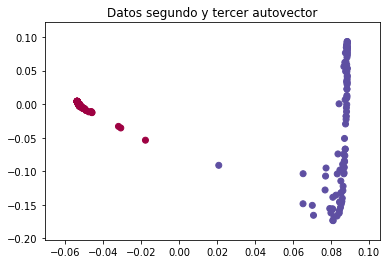

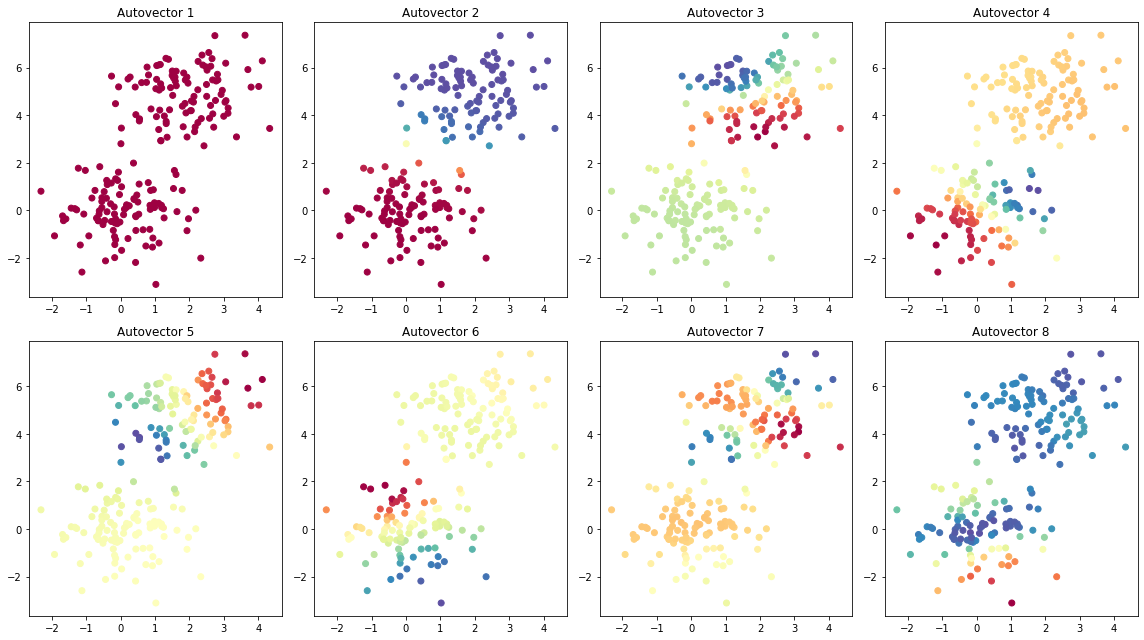

In [25]:
plt.figure()
plt.scatter(V[:,1],V[:,2],c=y);
plt.title('Datos segundo y tercer autovector');

plt.figure(figsize=(16,9))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.scatter(X[:,0],X[:,1],c=np.around(V[:,i],4));
    plt.title('Autovector {}'.format(i+1))
    
plt.tight_layout()

## Matriz Laplaciana Normalizada

Es posible realizar un análisis equivalente, sin necesidad de computar el grafo. Se puede construir una matriz Laplaciana normalizada $ L = D^{-1/2} W D^{-1/2} $ donde $W$ es la matriz de afinidad $ W = {\displaystyle e^{-\gamma\|s_{1}-s_{2}\|^{2}}} $

$\gamma$ controla cuan cerca se considera a los puntos, en un sentido similar al parámetro que asigna la cantidad de vecinos. 

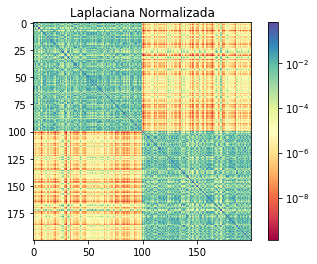

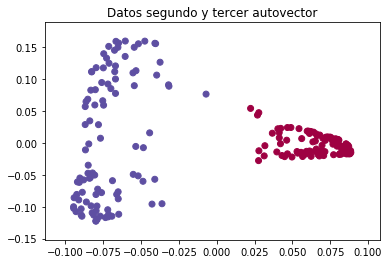

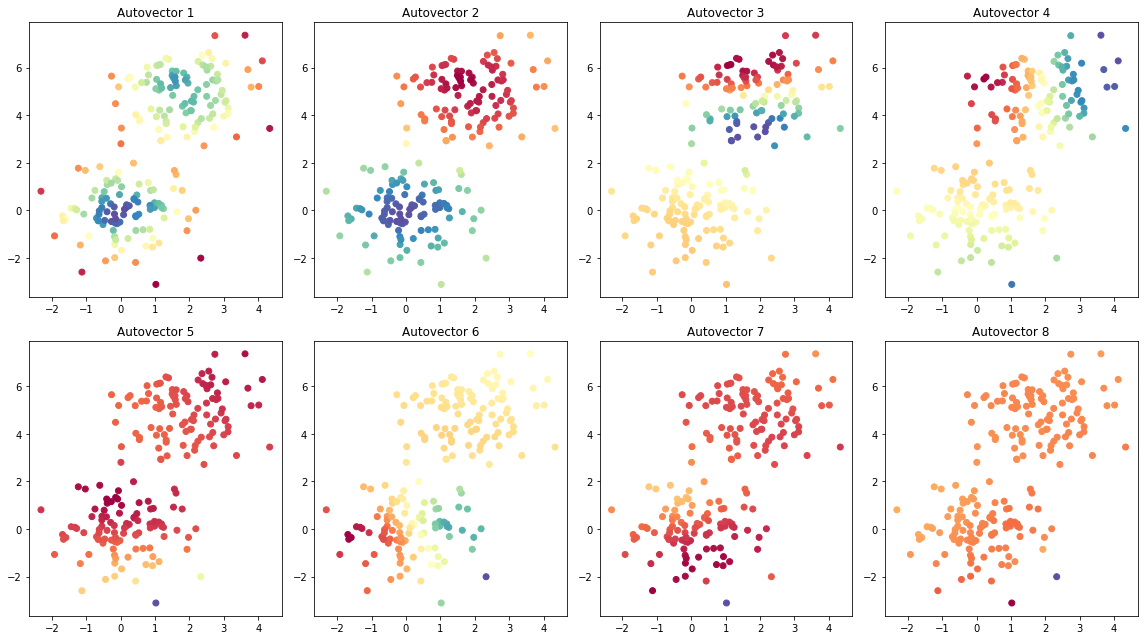

In [26]:
C = squareform(pdist(X,metric='euclidean'))
gamma = 2
W = np.exp(-gamma*C)
diagonal = W.sum(1)
diagonal_sqrt = 1.0/np.sqrt(diagonal)
diagonal_sqrt[np.isinf(diagonal_sqrt)] = 0
DH = np.diag(diagonal_sqrt)
L = DH.dot(W.dot(DH))

plt.imshow(L, norm=colors.LogNorm(vmin=L.min(), vmax=L.max()))
plt.colorbar();
plt.title('Laplaciana Normalizada')

d, V = np.linalg.eig(L)

idx = np.argsort(d)[::-1]
d = d[idx]
V = V[:,idx].real

plt.figure()
plt.scatter(V[:,1],V[:,2],c=y);
plt.title('Datos segundo y tercer autovector');


plt.figure(figsize=(16,9))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.scatter(X[:,0],X[:,1],c=V[:,i]);
    plt.title('Autovector {}'.format(i+1))
    
plt.tight_layout()

# Clustering Espectral

Simplemente utilizar algún conjunto de autovectores como nuevas features y realizar KMeans con ellos

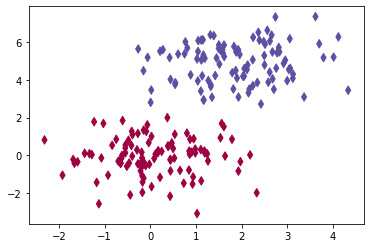

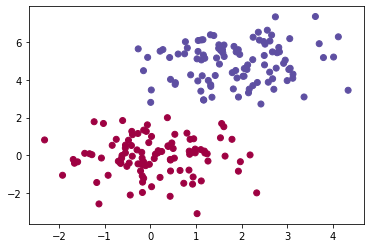

In [27]:
km = KMeans(n_clusters=2)
km.fit(V[:,1:2]);
plt.scatter(X[:,0], X[:,1], c=y, marker='d');
plt.figure()
plt.scatter(X[:,0], X[:,1], c=km.labels_);

## Exploración de parámetros

Exploremos el valor que determina la escala en el cómputo de la afinidad en el siguiente dataset

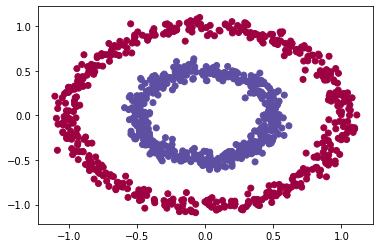

In [28]:
n_samples = 1000
X,y = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05,shuffle=False)
plt.scatter(X[:,0],X[:,1],c=y);

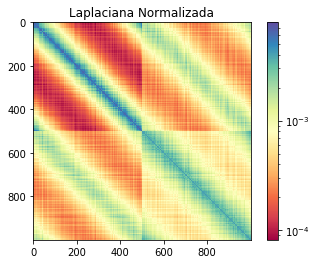

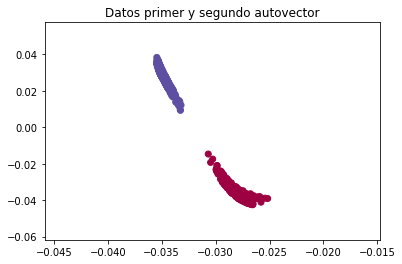

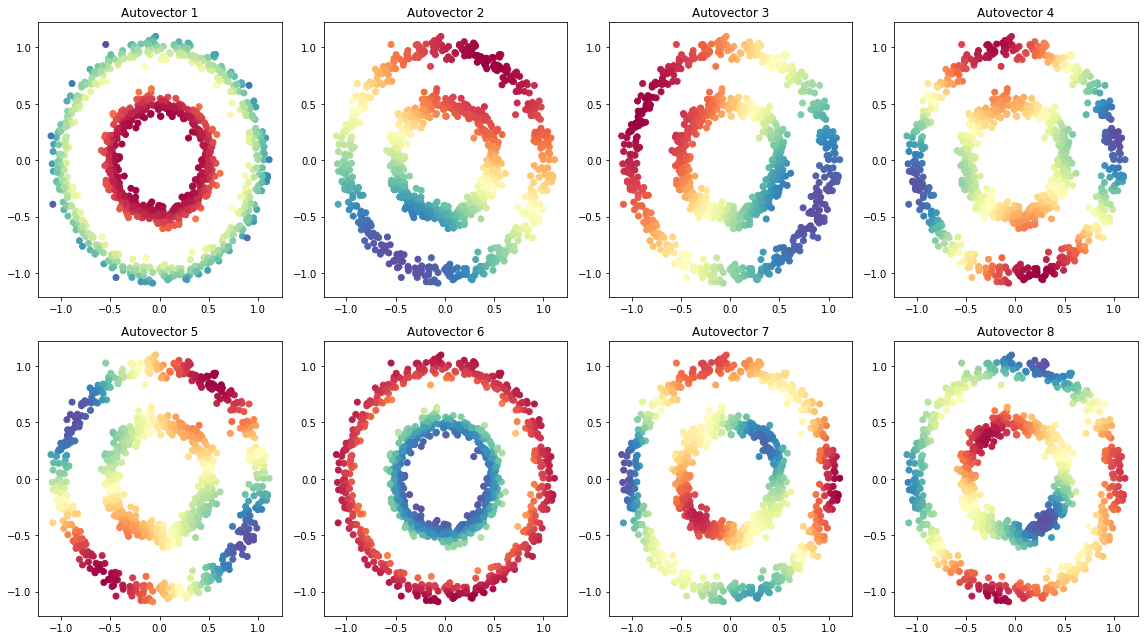

In [29]:
C = squareform(pdist(X,metric='euclidean'))
gamma = 2
W = np.exp(-gamma*C)
diagonal = W.sum(1)
diagonal_sqrt = 1.0/np.sqrt(diagonal)
diagonal_sqrt[np.isinf(diagonal_sqrt)] = 0
DH = np.diag(diagonal_sqrt)
L = DH.dot(W.dot(DH))

plt.imshow(L, norm=colors.LogNorm(vmin=L.min(), vmax=L.max()))
plt.colorbar();
plt.title('Laplaciana Normalizada')

d, V = np.linalg.eig(L)

idx = np.argsort(d)[::-1]
d = d[idx]
V = V[:,idx].real

plt.figure()
plt.scatter(V[:,0],V[:,5],c=y);
plt.title('Datos primer y segundo autovector');


plt.figure(figsize=(16,9))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.scatter(X[:,0],X[:,1],c=V[:,i]);
    plt.title('Autovector {}'.format(i+1))
    
plt.tight_layout()

En el método spectral clustering de sklearn podemos variarparámetro n_neighbors.

In [30]:
data = []
for n_neighbors in [2,3,4,5,10,20,40,80]:
    sc = SpectralClustering(n_clusters=2, n_neighbors=n_neighbors, affinity='nearest_neighbors')
    sc.fit(X),
    data.append({'rand_score': adjusted_rand_score(y, sc.labels_), 
                 'silhouette': silhouette_score(X,sc.labels_),
                 'n_neighbors': n_neighbors,
                 'labels': sc.labels_
                })
df = pd.DataFrame(data).set_index('n_neighbors',drop=True)

/home/zero/git/virtualenv/dmcyt2019/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/zero/git/virtualenv/dmcyt2019/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/zero/git/virtualenv/dmcyt2019/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/zero/git/virtualenv/dmcyt2019/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.

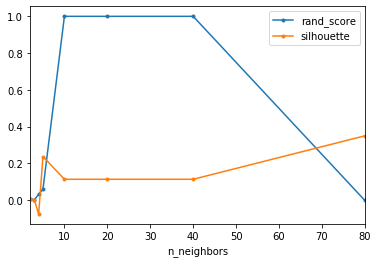

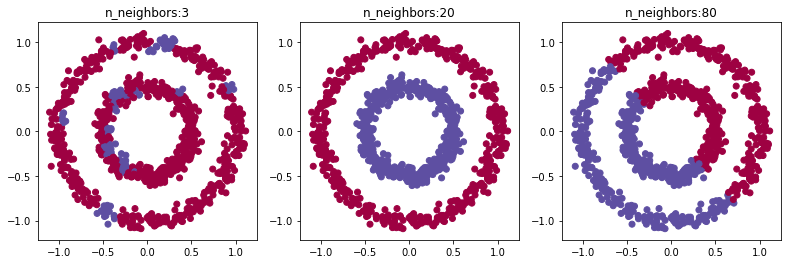

In [31]:
df.plot(style='.-');
plt.figure(figsize=(18,4))
for i,n_neighbors in enumerate([3,20,80]):
    k = np.where(df.index>=n_neighbors)[0][0]
    plt.subplot(1,4,i+1)
    plt.scatter(X[:,0],X[:,1],c=df.iloc[k].labels);   
    plt.title('n_neighbors:{}'.format(n_neighbors))

O podemos variar el parámetro gamma, la escala de la afinidad y ver como se pasa de un agrupamiento más global a uno más basado en las conexiones locales.

In [32]:
data = []
for gamma in np.linspace(18,25,50):
    sc = SpectralClustering(n_clusters=2,gamma=gamma)
    sc.fit(X)
    data.append({'rand_score': adjusted_rand_score(y, sc.labels_), 
                 'silhouette': silhouette_score(X,sc.labels_),
                 'gamma': gamma,
                 'labels': sc.labels_
                })
df = pd.DataFrame(data).set_index('gamma',drop=True)

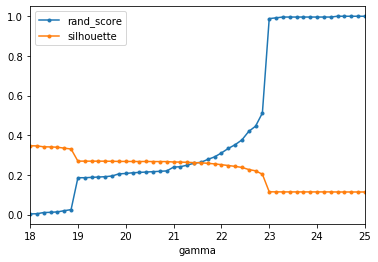

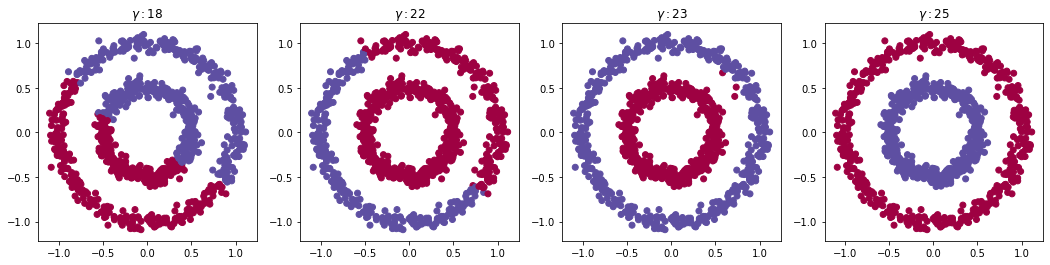

In [33]:
df.plot(style='.-');
plt.figure(figsize=(18,4))
for i,gamma in enumerate([18,22,23,25]):
    k = np.where(df.index>=gamma)[0][0]
    plt.subplot(1,4,i+1)
    plt.scatter(X[:,0],X[:,1],c=df.iloc[k].labels);   
    plt.title('$\gamma:{}$'.format(gamma))

# Un poco de físca de yapa: Modos de oscilación 

Si generamos una red de puntos emulando una superficie de algún material y realizamos el análisis espectral de autovectores con el Laplaciano, podemos ver modos de oscilación del material (no son el cálculo exacto, pero son representativos). En este caso probamos con una grilla regular

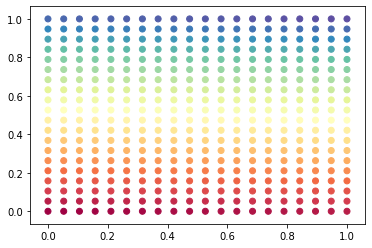

In [34]:
X,Y = np.meshgrid(np.linspace(0,1,20),np.linspace(0,1,20))
X = np.vstack([X.flatten(),Y.flatten()]).T
plt.scatter(X[:,0],X[:,1],c=np.arange(len(X)));

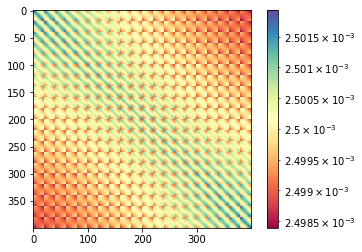

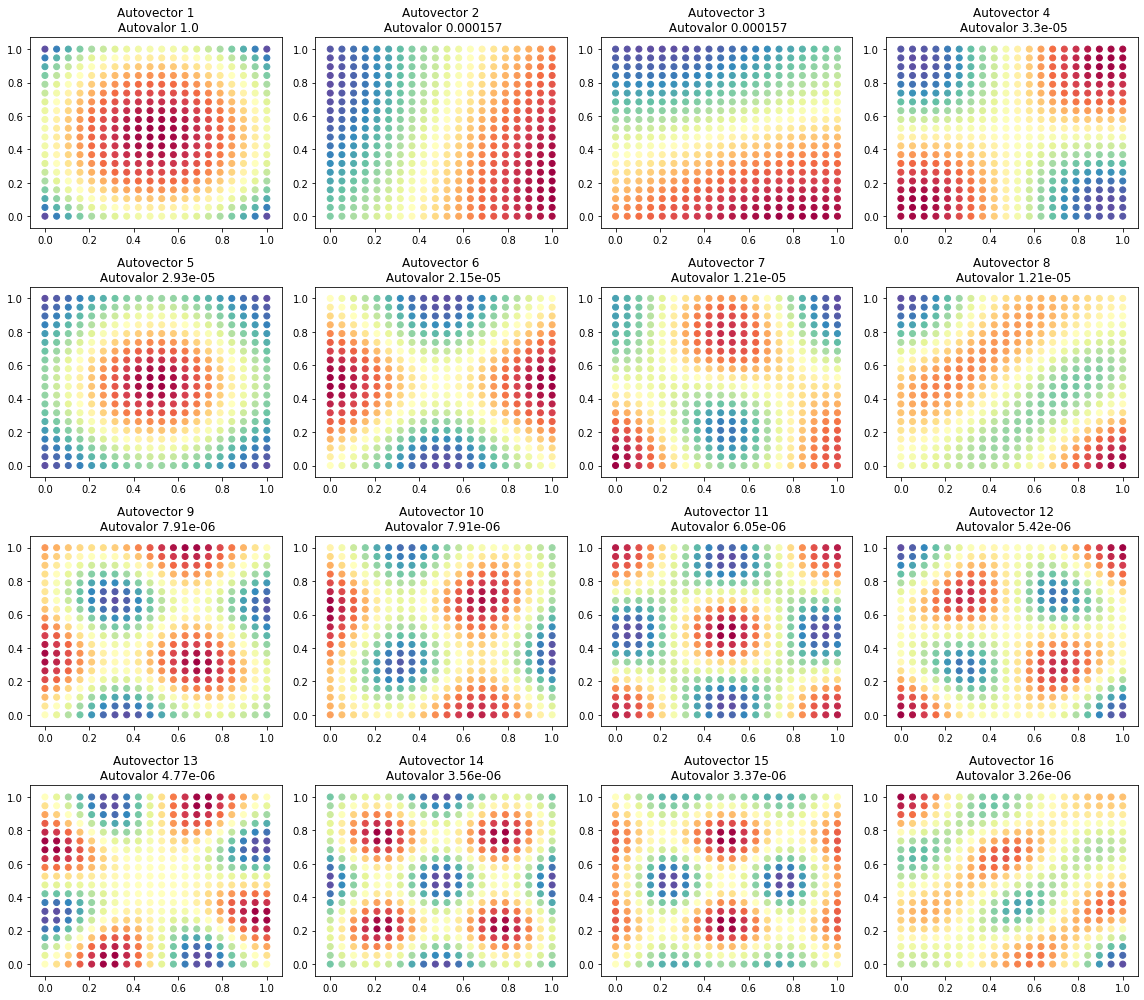

In [35]:
C = squareform(pdist(X,metric='euclidean'))
W = np.exp(-0.001*C)
diagonal = W.sum(1)
diagonal_sqrt = 1.0/np.sqrt(diagonal)
diagonal_sqrt[np.isinf(diagonal_sqrt)] = 0
DH = np.diag(diagonal_sqrt)
L = DH.dot(W.dot(DH))

plt.imshow(L, norm=colors.LogNorm(vmin=L.min(), vmax=L.max()))
plt.colorbar();

d, V = np.linalg.eig(L)

idx = np.argsort(d)[::-1]
d = d[idx].real
V = V[:,idx].real

plt.figure(figsize=(16,14))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.scatter(X[:,0],X[:,1],c=V[:,i].real);
    plt.title('Autovector {}\n Autovalor {:0.3}'.format(i+1,d[i]))
    
plt.tight_layout()

# Reducción de la dimensionalidad con análisis espectral

Los autovectores hallados al descomponer la matrices pueden utilizarse para reducir la dimensionalidad del conjunto de datos inicial.

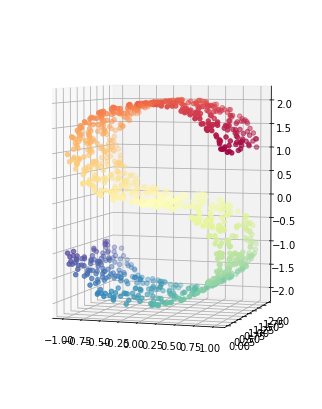

In [36]:
from mpl_toolkits.mplot3d import Axes3D

X, color = datasets.samples_generator.make_s_curve(1000, random_state=0)
# para deformar las dimensiones 
# X[:,1] = X[:,1]*10
fig = plt.figure(figsize=(32,16))
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color)
ax.view_init(4, -72)

Si filtramos una dimension con PCA, obtenemos las 2 dimensiones que más explican la varianza.


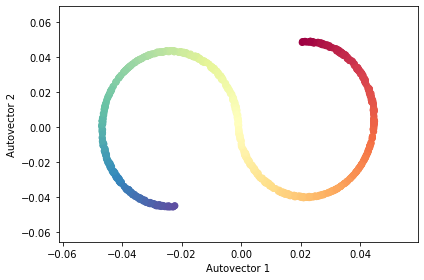

In [37]:
n, m = X.shape
Xcentered = X - X.mean(0)
C = np.dot(Xcentered, Xcentered.T) / (n-1)

d, V = np.linalg.eig(C)

ix = np.argsort(d)[::-1]
d = d[ix]
V = V[:,ix].real

plt.scatter(V[:,0],V[:,1],c=color);
plt.xlabel('Autovector 1')
plt.ylabel('Autovector 2');

plt.tight_layout()

Con matriz de distancia euclidea

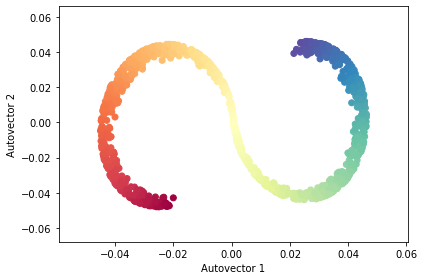

In [38]:
n, m = X.shape
C = squareform(pdist(X,metric='euclidean'))

d, V = np.linalg.eig(C)

idx = np.argsort(d)
d = d[idx]
V = V[:,idx].real

plt.scatter(V[:,0],V[:,1],c=color);
plt.xlabel('Autovector 1')
plt.ylabel('Autovector 2');

plt.tight_layout()

Con Laplaciano normalizado

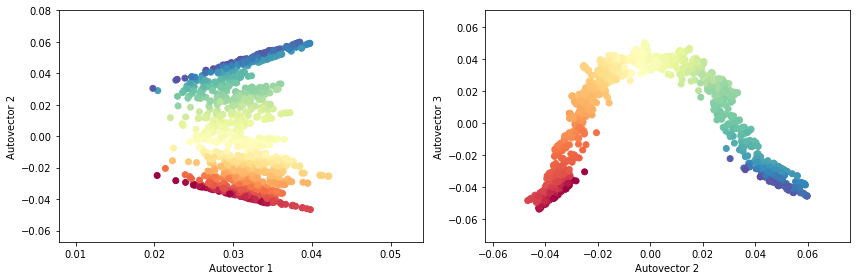

In [39]:
C = squareform(pdist(X,metric='euclidean'))
W = np.exp(-10*C)
diagonal = W.sum(1)
diagonal_sqrt = 1.0/np.sqrt(diagonal)
diagonal_sqrt[np.isinf(diagonal_sqrt)] = 0
DH = np.diag(diagonal_sqrt)
L = DH.dot(W.dot(DH))

d, V = np.linalg.eig(L)

idx = np.argsort(d)[::-1]
d = d[idx]
V = V[:,idx].real

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(V[:,0],V[:,1],c=color);
plt.xlabel('Autovector 1')
plt.ylabel('Autovector 2')

plt.subplot(1,2,2)
plt.scatter(V[:,1],V[:,2],c=color);
plt.xlabel('Autovector 2')
plt.ylabel('Autovector 3')

plt.tight_layout()

# Ejemplo: Detección de habla en audio

Vamos a analizar un audio que contiene habla y no habla. Mediante análisis espectral de una matriz de recurrencia podemos discriminar las partes de habla de las de no habla

In [40]:
import librosa
import urllib

url = 'http://www.elortiba.org/old/sounds/apollo11.mp3'

filename, message = urllib.request.urlretrieve(url,'sample.wav')
audio, sr = librosa.load(filename)
Audio(audio,rate=sr)

/home/zero/git/virtualenv/dmcyt2019/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Calculamos features de audio, en este caso Mel Spectrogram

(560, 128)

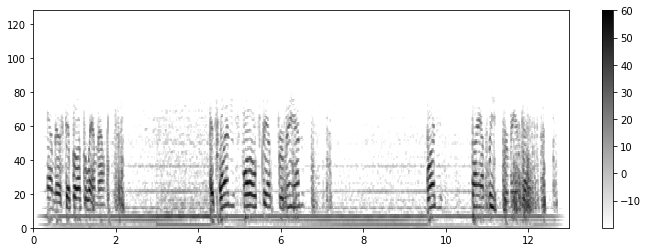

In [41]:
X = librosa.amplitude_to_db( librosa.feature.melspectrogram(audio, sr=sr, n_mels=128, fmax=8000) ).T
t = librosa.frames_to_time(np.arange(X.shape[0]),sr=sr, )

plt.figure(figsize=(12,4))
plt.imshow(X.T,aspect='auto',origin='bottom',cmap=plt.cm.gray_r, extent=[0,t[-1],0,X.shape[1]])

plt.colorbar();
X.shape

Matriz de recurrencia a partir del Laplaciano normalizado de los features de audio.

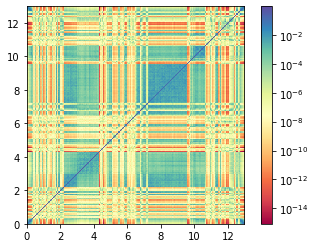

In [42]:
C = squareform(pdist(X,metric='euclidean'))
W = np.exp(-0.1*C)
diagonal = W.sum(1)
diagonal_sqrt = 1.0/np.sqrt(diagonal)
diagonal_sqrt[np.isinf(diagonal_sqrt)] = 0
DH = np.diag(diagonal_sqrt)
L = DH.dot(W.dot(DH))

plt.imshow(L, norm=colors.LogNorm(vmin=L.min(), vmax=L.max()),  extent=[0,t[-1],0,t[-1]], origin='bottom')
plt.colorbar();

d, V = np.linalg.eig(L)

idx = np.argsort(d)[::-1]
d = d[idx].real
V = V[:,idx].real

Se puede escuchar el audio y vizualidar el primero autovector en función del tiempo para analizar el resultado

In [43]:
def auxplot():
    plt.figure(figsize=(18,6))
    plt.plot(t,(V[:,0]+0.07)*20);
    return plt.gcf(), plt.gca()

audiofigure(auxplot, t[-1], sr = sr, audio_path='sample.wav')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.ImageMagickWriter'> instead.


# Referencias

SVD y PCA
https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

The elements of statistical learning (Vol. 1, No. 10). Capitulo 14.5. Friedman, J., Hastie, T., & Tibshirani, R. (2001). New York: Springer series in statistics.

Weiss, Y. (1999, September). Segmentation using eigenvectors: a unifying view. In Proceedings of the seventh IEEE international conference on computer vision (Vol. 2, pp. 975-982). IEEE.

Ng, A. Y., Jordan, M. I., & Weiss, Y. (2002). On spectral clustering: Analysis and an algorithm. In Advances in neural information processing systems (pp. 849-856).

http://blog.shriphani.com/2015/04/06/the-smallest-eigenvalues-of-a-graph-laplacian/

Mousazadeh, S., & Cohen, I. (2013). Voice activity detection in presence of transient noise using spectral clustering. IEEE Transactions on Audio, Speech, and Language Processing, 21(6), 1261-1271.